# Data Gathering By Python

# Naive Bayes with Labeled Text Data

In this document, my main work is to get credit-related tweet data from Twitter and use sentiment analysis to add a label for each tweet, including positive, negative and neutral sentiment. Then a classification model was built using Naive Bayes to classify the labels of the text.

In [1]:
import pandas as pd
import os
import time
import requests
import json
import csv
from tqdm import tqdm

import tweepy

import requests
import pandas as pd
import os

In [2]:
consumer_key = "inZ89PddRMaRQwE6GVqA3Q41O"
consumer_secret = "9MXxneTgvjgNxLgRWwZDto5SkadnHw5JkFcGKuRPqwMHU61ZMM"
access_token = "1555013004927705088-42uhpeSplVieHyeh7iWAm5Tk7uRu5G"
access_token_secret = "jERIeAGcoKGEju47LndLdypLBkxwzRzdtMHqDcs4cTO24"
bearer_token = "AAAAAAAAAAAAAAAAAAAAAHxTfgEAAAAAFoqGo6ZQ%2BYdXOC8pDIvIgRX0jJM%3DCnfeZi86Klf8HPAGUap5AoUjQN754ki2jjomd4ZhTLtcwGpg6q"

Get credit related data from Twitter using Twitter api.

In [3]:
query = "credit"
client = tweepy.Client(bearer_token= bearer_token)
tweets = tweepy.Paginator(client.search_recent_tweets, query = query, tweet_fields = ['text','author_id','created_at','lang'], max_results = 100).flatten(limit=250)
result = [[tweet.text, tweet.author_id,tweet.created_at,tweet.lang] for tweet in tweets]


In [4]:
text = [x[0] for x in result]

In [6]:
len(text)

250

Use a pipeline to remove stopwords and illegal symbols and emojis to make text data clean.

In [7]:
import re
from tqdm import tqdm
from typing import List

import spacy
from spacy.language import Language

pipeline_name = '2020ElectionTweets'


def camel_case_split(str):
    """ This function turns in #Biden2020 into Biden 2020 """
    return " ".join([wrd for wrd in re.findall(r'[A-Z](?:[a-z]+|[A-Z]*(?=[A-Z]|$))', str)])


@Language.component(pipeline_name)
def preprocess(doc):
    doc = [token for token in doc if not token.is_punct]
    # doc = [token for token in doc if not token.is_stop]
    doc = [token.text.lower().strip() for token in doc]
    doc = [token for token in doc if 0 < len(token) <= 12]
    return " ".join(doc)


class Pipeline:
    
    
    email_re = r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)
    *|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]
    |\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9]
    (?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}
    (?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:
    (?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])"""
    # replace = [ (pattern-to-replace, replacement),  ...]
    replace = [
        ("<[^>]*>", " "),
        (email_re, " "),                           # Matches emails
        (r"(?<=\d),(?=\d)", ""),                   # Remove commas in numbers
        (r"\d+", " "),                             # Map digits to special token <numbr>
        (r"[*\^\.$&@<>,\-/+{|}=?#:;'\"\[\]]", ""), # Punctuation and other junk
        (r"[\n\t\r]", " "),                        # Removes newlines, tabs, creturn
        (r"[^\x00-\x7F]+", ""),                    # Removes non-ascii chars
        (r"\\+", " "),                             # Removes double-backslashs
        (r"\s+n\s+", " "),                         # 'n' leftover from \\n
        (r"\s+", " ")                              # Strips extra whitespace
    ]
    
    def __init__(self):
        self.pipeline = spacy.load('en_core_web_sm')
        self.pipeline.add_pipe(pipeline_name);
        
    def __call__(self, *args, **kwargs):
        return self.transform(*args, **kwargs)

    def transform(self, doc: str):
        for repl in self.replace:
            doc = re.sub(repl[0], repl[1], doc)
        doc = camel_case_split(doc)
        return self.pipeline(doc)
    
pipeline = Pipeline();

In [8]:
from tqdm import tqdm

with tqdm(total=250) as bar:
    for i, ts in enumerate(zip(text)):
        text[i] = pipeline(str(ts))
        bar.update()

100%|██████████| 250/250 [00:01<00:00, 125.81it/s]


Plot a wordcloud to see some main keywords of the dataset.

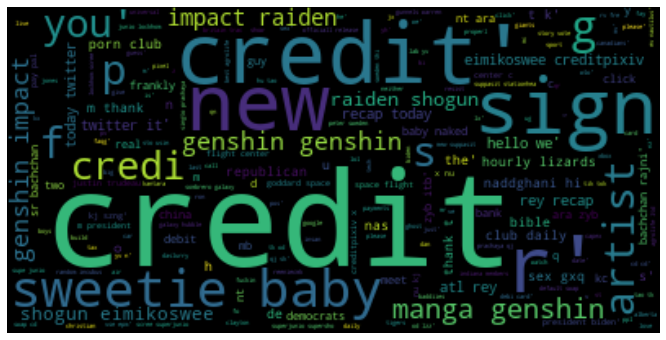

In [35]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
wordcloud = WordCloud().generate(str(text))
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Convert it into a data frame.

In [15]:
txt = pd.DataFrame(text)
txt.columns = ['text']

In [16]:
txt

,text
0,r
1,r q group media news ntv telugu live the
2,dw universal credit live jvlf
3,v ns c please just taking
4,r manga genshin genshin impact raiden shogun e...
...,...
245,its christine winter much
246,dan rather i m hillary clinton hillary
247,r resist pay pal guess
248,r sweetie baby meet sign no date


Use nltk tool to add label for each text data, including positive, negative and neutral sentiments.

In [20]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     c:\Users\wsy\anaconda3\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [21]:
sentiments = SentimentIntensityAnalyzer()
txt["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in txt["text"]]
txt["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in txt["text"]]
txt["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in txt["text"]]
txt['Compound'] = [sentiments.polarity_scores(i)["compound"] for i in txt["text"]]
txt.head()

,text,Positive,Negative,Neutral,Compound
0,r,0.000,0.0,0.000,0.0000
1,r q group media news ntv telugu live the,0.000,0.0,1.000,0.0000
2,dw universal credit live jvlf,0.394,0.0,0.606,0.3818
3,v ns c please just taking,0.434,0.0,0.566,0.3182
4,r manga genshin genshin impact raiden shogun e...,0.000,0.0,1.000,0.0000


In [22]:
score = txt["Compound"].values
sentiment = []
for i in score:
    if i >= 0.05 :
        sentiment.append('Positive')
    elif i <= -0.05 :
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
txt["Sentiment"] = sentiment
txt.head()

,text,Positive,Negative,Neutral,Compound,Sentiment
0,r,0.000,0.0,0.000,0.0000,Neutral
1,r q group media news ntv telugu live the,0.000,0.0,1.000,0.0000,Neutral
2,dw universal credit live jvlf,0.394,0.0,0.606,0.3818,Positive
3,v ns c please just taking,0.434,0.0,0.566,0.3182,Positive
4,r manga genshin genshin impact raiden shogun e...,0.000,0.0,1.000,0.0000,Neutral


Count the number of each category.

In [23]:
print(txt["Sentiment"].value_counts())

Neutral     137
Positive     89
Negative     24
Name: Sentiment, dtype: int64


Convert string label into number.

In [24]:
txt["sentiment"] = txt["Sentiment"].map({"Neutral": 0, "Positive": 1, "Negative": 2})
txt.head()

,text,Positive,Negative,Neutral,Compound,Sentiment,sentiment
0,r,0.000,0.0,0.000,0.0000,Neutral,0
1,r q group media news ntv telugu live the,0.000,0.0,1.000,0.0000,Neutral,0
2,dw universal credit live jvlf,0.394,0.0,0.606,0.3818,Positive,1
3,v ns c please just taking,0.434,0.0,0.566,0.3182,Positive,1
4,r manga genshin genshin impact raiden shogun e...,0.000,0.0,1.000,0.0000,Neutral,0


CounterVectorization before NB

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(txt['text'])

In [27]:
import numpy as np, pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
sns.set() # use seaborn plotting style

Split features and labels and split training and test set.

In [29]:
X = txt['text']
y = txt['sentiment']

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Build a Multinomial Naive Bayes Model through sklearn and make predictions.

In [32]:
# Build the model
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
# Train the model using the training data
model.fit(X_train, y_train)
# Predict the categories of the test data
predicted_categories = model.predict(X_test)

plot the confusion matrix

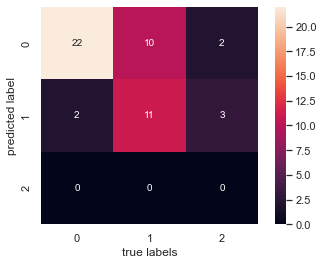

The accuracy is 0.66


In [33]:
mat = confusion_matrix(y_test, predicted_categories)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d")
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()
print("The accuracy is {}".format(accuracy_score(y_test, predicted_categories)))

Print the confusion matrix.

In [37]:
print(confusion_matrix(y_test, predicted_categories))

[[22  2  0]
 [10 11  0]
 [ 2  3  0]]


# Result Summaries

Generally speaking, the model prediction accuracy is 0.66. It performs well but definitely not the best. I think it is partly because the dataset is too small and the content is not completely clean. The twitter data fetched from twitter api contains information from various language and it may not make sense to analyze the complex contents all together. But the result is acceptable.